# Graph-based Model
Our novel idea is to construct a graph-structured model to detect frauds from the provider - beneficiaries connection.
In our graph-structured dataset, we have:
- Relationships from Provider to Beneficiaries
- Relationships from Provider to Physician

Both graphs will have the edge weights equal to the number of claims

In [30]:
# Import libraries
import warnings

warnings.filterwarnings("ignore") # To hide deprecation warnings arising from underlying function calls made by featuretools

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option("display.max_columns", 500)

### 8.1 Import Preprocessed Datasets 

We will only take the relevant columns to be used as nodes: Provider, Beneficiary and Physician.

The edges and its weight will represent the number of claims/rows that each pair of Provider-Beneficiary or Provider-Physician appears in our dataset.

In [2]:
# Load preprocessed datasets
X_train1 = pd.read_csv('X_train1.csv')
X_train2 = pd.read_csv('X_train2.csv')
y_labels = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
X_labeled = pd.concat([X_train1, X_train2], ignore_index=True) # Combine into 1 training set
# only take our relevant columns as nodes columns
X_nodes = X_labeled[['Provider','BeneID', 'AttendingPhysician_ce', 'OperatingPhysician_ce', 'OtherPhysician_ce']]

# As labels were provided for fraudulent providers only, we will retain the providers in our y_labels only.
y_providers = y_labels[['Provider', 'PotentialFraud']].drop_duplicates(ignore_index=True)


In [16]:
# Construct 3 edgelist datasets for our 3 graphs
# Graph 1: Provider - Beneficiaries
X_provider_bene_edgelists = X_nodes.groupby(['Provider', 'BeneID']).size().reset_index(name='Count')
X_provider_bene_edgelists['EdgeKey'] = 'Provider-Bene'

# Graph 2: Provider - Physicians
X_nodes_provider_physician = X_nodes[['Provider', 'AttendingPhysician_ce', 'OperatingPhysician_ce', 'OtherPhysician_ce']]
# melt the DataFrame, combining all 3 physician codes into 1
X_provider_physician_melt = pd.melt(X_nodes_provider_physician, id_vars=['Provider'], value_name='Physician')
# drop the variable name column and 0 value
X_provider_physician_melt = X_provider_physician_melt[X_provider_physician_melt['Physician'] != 0]
X_provider_physician_edgelists = X_provider_physician_melt.groupby(['Provider', 'Physician']).size().reset_index(name='Count')
X_provider_physician_edgelists['EdgeKey'] = 'Provider-Phys'

# Graph 3: Beneficiaries - Physicians
X_nodes_bene_physician = X_nodes[['BeneID', 'AttendingPhysician_ce', 'OperatingPhysician_ce', 'OtherPhysician_ce']]
# melt the DataFrame, combining all 3 physician codes into 1
X_bene_physician_melt = pd.melt(X_nodes_bene_physician, id_vars=['BeneID'], value_name='Physician')
# drop the variable name column and 0 value
X_bene_physician_melt = X_bene_physician_melt[X_bene_physician_melt['Physician'] != 0]
X_bene_physician_edgelists = X_bene_physician_melt.groupby(['BeneID', 'Physician']).size().reset_index(name='Count')
X_bene_physician_edgelists['EdgeKey'] = 'Bene-Phys'

In [17]:
display(X_provider_bene_edgelists.head(2))
display(X_provider_physician_edgelists.head(2))
display(X_bene_physician_edgelists.head(2))

,Provider,BeneID,Count,EdgeKey
0,PRV51001,BENE102690,1,Provider-Bene
1,PRV51001,BENE106078,1,Provider-Bene


,Provider,Physician,Count,EdgeKey
0,PRV51001,1.0,9,Provider-Phys
1,PRV51001,2.0,8,Provider-Phys


,BeneID,Physician,Count,EdgeKey
0,BENE100000,14.0,1,Bene-Phys
1,BENE100000,17.0,1,Bene-Phys


{('PRV51017',
  'BENE147971'): Text(0.8310698179373215, -0.2770868806867197, '1'),
 ('PRV55490',
  'BENE102388'): Text(0.8922650091083322, -0.17663042713252486, '1'),
 ('PRV56689', 'BENE93776'): Text(0.29978739870063836, 0.8836298731444976, '1'),
 ('PRV55039', 'BENE99979'): Text(-0.18265060426706548, 0.716585706660384, '1'),
 ('PRV55039',
  'BENE156638'): Text(-0.1855459007773338, 0.6912190294665876, '6'),
 ('PRV55163',
  'BENE153540'): Text(0.4349757577514898, -0.6178102855523615, '1'),
 ('PRV53121',
  'BENE104195'): Text(-0.38020739628892675, 0.7298113227236285, '2'),
 ('PRV51954',
  'BENE109627'): Text(-0.07250462252447855, -0.23907527898263486, '1'),
 ('PRV54887',
  'BENE20564'): Text(0.43107163177344154, -0.7289244621866116, '1'),
 ('PRV51176', 'BENE63724'): Text(0.33222856503632325, -0.87910366269395, '1'),
 ('PRV51176', 'BENE55057'): Text(0.3587063247320454, -0.882540584586602, '1'),
 ('PRV56733', 'BENE38450'): Text(0.6484152592335596, -0.5030649237219977, '1'),
 ('PRV52386', 'B

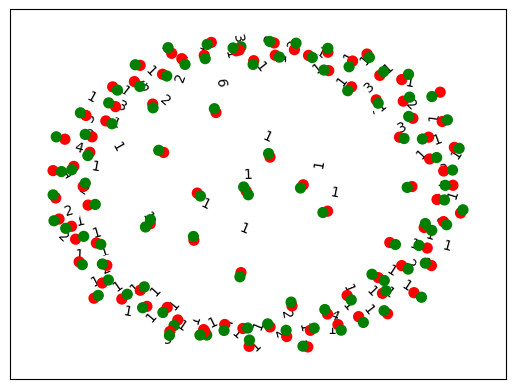

In [5]:
# Graph 0 - Subgraph of the data for visualisation
df_plotting = X_provider_bene_edgelists.sample(n=100, random_state=1)
H = nx.from_pandas_edgelist(df_plotting, source='Provider', target = 'BeneID', edge_attr="Count")
color_map = ['red' if node.startswith('PRV') else 'green' for node in H] 
nx.draw_networkx(H, pos=nx.spring_layout(H), with_labels=False, node_color=color_map, node_size=50)
nx.draw_networkx_edge_labels(H,pos=nx.spring_layout(H),edge_labels=nx.get_edge_attributes(H,'Count'))

In [19]:
# Graph 1 - Relationships between Provider and Beneficiaries
G_1 = nx.from_pandas_edgelist(X_provider_bene_edgelists, source='Provider', target = 'BeneID', edge_key="EdgeKey",
                            edge_attr="Count")

# Graph 2 - Relationships between Provider and Physicians
G_2 = nx.from_pandas_edgelist(X_provider_physician_edgelists, source='Provider', target = 'Physician', edge_key="EdgeKey",
                            edge_attr="Count")

# Graph 3 - Relationships between Provider and Physicians
G_3 = nx.from_pandas_edgelist(X_bene_physician_edgelists, source='BeneID', target = 'Physician', edge_key="EdgeKey",
                            edge_attr="Count")

In [20]:
# combine graphs
G_combined = nx.compose(G_3, nx.compose(G_1, G_2))

In [22]:
print(G_combined.edges("BENE102690"))

[('BENE102690', 14.0), ('BENE102690', 4.0), ('BENE102690', 7.0), ('BENE102690', 10.0), ('BENE102690', 16.0), ('BENE102690', 1.0), ('BENE102690', 29.0), ('BENE102690', 2.0), ('BENE102690', 11.0), ('BENE102690', 3.0), ('BENE102690', 56.0), ('BENE102690', 322.0), ('BENE102690', 'PRV51001'), ('BENE102690', 'PRV51036'), ('BENE102690', 'PRV51042'), ('BENE102690', 'PRV51059'), ('BENE102690', 'PRV51067'), ('BENE102690', 'PRV51089'), ('BENE102690', 'PRV56426'), ('BENE102690', 'PRV56454')]


### 8.2 Approach with Graph-structured Data
We have 2 approaches to handle this graph-structured data:

Approach 1: Use GNN Models for Clustering Detection and Provider Node Classification (on the combine MultiDiGraph G_combined)

Approach 2: On the Provider-Beneficiary Graph G_1 and Provider-Physician Graph G_2, extract useful metrics for Provider Node:
- Degree of the nodes
- Closeness Centrality Coefficient
- Eigenvector Centrality
- PageRank
which can be used as featured in our conventional machine learning algoritms

#### Approach 1: Applying GNN for Node Classification

In [106]:
import torch
from torch_geometric.transforms import NormalizeFeatures

In [102]:
# Import relevant libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

#### Approach 2: Extracting useful Graph Metrics Features

In [23]:
provider_graph_features = y_providers.copy()

In [27]:
# defining a dictionary of graph features
graph_features_dict = {
    'degree': lambda x : dict(x.degree(weight="Count")),
    'eigenvector_centrality': lambda x : nx.eigenvector_centrality_numpy(x, weight="Count"),
    'clustering_coefficient': lambda x : nx.clustering(x, weight="Count"),
    'pagerank': lambda x : nx.pagerank(x, weight="Count")
}

# computing graph features for in the combined graph
graph_features = pd.DataFrame()
for info, func in graph_features_dict.items():
    temp_1 = pd.DataFrame.from_dict(func(G_combined), orient='index').rename(columns = {0 : info}).reset_index()
    if graph_features.empty:
        graph_features = temp_1
    else:
        graph_features = graph_features.merge(temp_1, on='index')
    print(f"Complete calculating {info}")

# only take values of Provider nodes
provider_graph_features = provider_graph_features.merge(graph_features, left_on='Provider',right_on='index', how='left').drop('index', axis=1)

Complete calculating degree
Complete calculating eigenvector_centrality
Complete calculating clustering_coefficient
Complete calculating pagerank


In [28]:
provider_graph_features

,Provider,PotentialFraud,degree,eigenvector_centrality,clustering_coefficient,pagerank
0,PRV55912,1,287,5.236476e-06,0.000049,0.000060
1,PRV55907,0,617,7.374815e-06,0.000033,0.000125
2,PRV56046,0,54,3.487085e-07,0.000122,0.000012
3,PRV52405,0,233,6.746402e-07,0.000051,0.000046
4,PRV56614,0,71,1.020819e-06,0.000085,0.000017
...,...,...,...,...,...,...
5405,PRV54302,0,3,9.905474e-09,0.000537,0.000002
5406,PRV57762,0,2,3.910860e-08,0.000338,0.000001
5407,PRV51577,0,2,2.776062e-07,0.000338,0.000001
5408,PRV53083,0,2,3.910374e-08,0.000338,0.000001


In [32]:
provider_graph_features.to_csv('provider_graph_features.csv', index=False)

<Axes: >

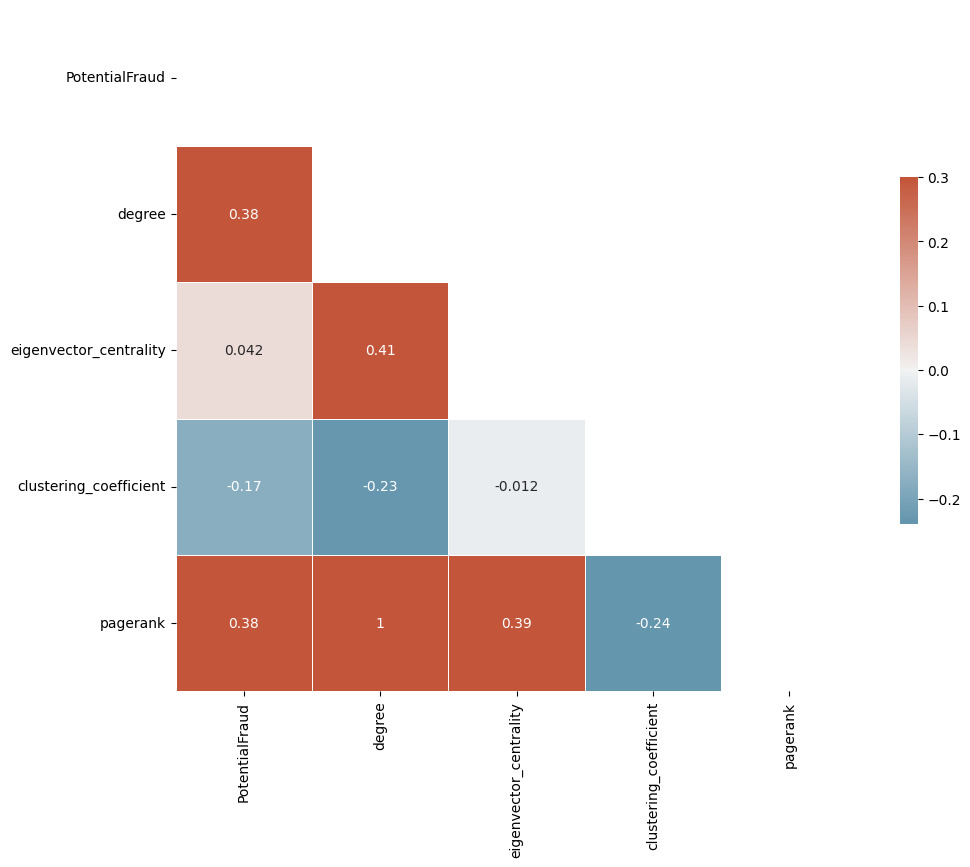

In [31]:
corr_data = provider_graph_features[['PotentialFraud',
                'degree',
                'eigenvector_centrality',
                'clustering_coefficient',
                'pagerank']]

# Compute the correlation matrix
corr = corr_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})